In [2]:
%reset -f

import sys

import numpy as np
import pandas as pd
import time
sys.path.insert(
    1, '/Users/haas/Documents/Masters/ml_lattice_qcd'
)

import random

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from activation_functions import *
from FFNN import FFNN

# import accuracy score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_squared_error,
)
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, SeparableConv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from utils import *

cmt = 1 / 2.54
sns.set_palette('pastel')

### 1. Generating data above and below the critial temperature for Ahmed's blind check.
 

In [3]:
data = pd.read_csv("../Ising/data/50/s3_cfg_L50_A0_mc1000000_burn1_tl1.000_tu3.530.csv", header=None)
X = data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1][::50].to_numpy() # take every 50th collumn

X = X.reshape(len(y), 50*50)
y = y.reshape(len(y), 1)

#tc = 2.269

# get 5 random configurations with corresponding y between 1.0 and 1.7
# get 5 random configurations with corresponding y between 2.8 and 3.5
idx_above = np.random.choice(np.where((y > 1.0) & (y < 1.7))[0], 5)
idx_below = np.random.choice(np.where((y > 2.8) & (y < 3.5))[0], 5)

# get the according configurations
X_above = X[idx_above]
X_below = X[idx_below]

# get the according y
y_above = y[idx_above]
y_below = y[idx_below]

print("y above: ", y_above)
print("y below: ", y_below)

# save the configurations to different txt files
for i in range(5):
    np.savetxt(f"../Ising/data/50/{i}.txt", X_above[i].reshape(50, 50))
    np.savetxt(f"../Ising/data/50/{i + 5}.txt", X_below[i].reshape(50, 50))



y above:  [[1.62]
 [1.63]
 [1.33]
 [1.32]
 [1.09]]
y below:  [[3.13]
 [2.81]
 [3.07]
 [3.46]
 [3.25]]


### Part 2.1) Training classification on the whole range (including the neighborhood of critical temperature) and predicting Ahmeds files as below or above critical temp

2023-04-05 15:11:02.834454: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8/8 [==============================] - 0s 5ms/step
accuracy with CNN =  0.9881422924901185


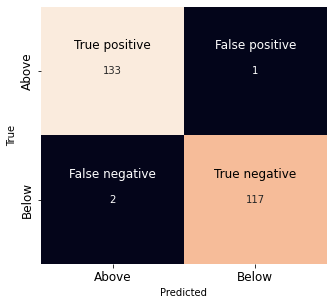

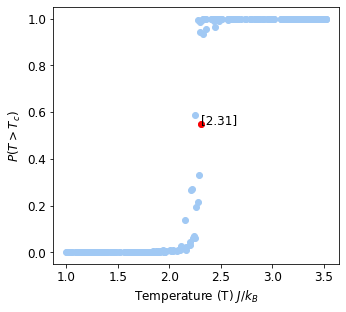

In [4]:
# classification prediction of the Ising model
Xtrain, Xtest, ytrain, ytest = Ising.load_data()

y_test_copy = ytest.copy()

true_tc = 2.269185314213022
ytrain[ytrain < true_tc] = 0
ytrain[ytrain >= true_tc] = 1
ytest[ytest < true_tc] = 0
ytest[ytest >= true_tc] = 1

# shuffle y_copy in the exact same way as Xtrain and Xtest

# use the convolutional neural network to classify the data into two classes
# first reshape Xtrain and Xtest to 4D arrays
Xtrain = Xtrain.reshape(Xtrain.shape[0], 50, 50, 1)
Xtest = Xtest.reshape(Xtest.shape[0], 50, 50, 1)

# create model
model = Sequential()
# add model layers
l2_reg = regularizers.l2(0.01)
model.add(
    Conv2D(
        6,
        kernel_size=5,
        activation='leaky_relu',
        input_shape=(50, 50, 1),
        kernel_regularizer=l2_reg,
        padding='same',
    )
)
# model.add(AveragePooling2D(pool_size=(4, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(
    Conv2D(
        16,
        kernel_size=5,
        activation='leaky_relu',
        kernel_regularizer=l2_reg,
        padding='same',
    )
)
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(AveragePooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(120, activation='relu', kernel_regularizer=l2_reg))
model.add(Dense(84, activation='relu', kernel_regularizer=l2_reg))
model.add(Dense(1, activation='sigmoid'))

# compile model using accuracy to measure model performance
sgd = SGD(learning_rate=0.001, decay=5e-6, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=100, verbose=0)

# evaluate the model
pred = model.predict(Xtest)
soft_pred = pred
hard_pred = np.round(pred)
acc = accuracy_score(ytest, hard_pred)
print('accuracy with CNN = ', acc)
# accuracy with CNN =  0.9920948616600791

# plot confusion matrix with seaborn
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
cm = confusion_matrix(ytest, hard_pred)
sns.heatmap(cm, annot=True, fmt='d')
# remove colorbar
plt.gca().collections[0].colorbar.remove()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# label as true positive, true negative, false positive, false negative
plt.text(
    0.5,
    0.3,
    'True positive',
    ha='center',
    va='center',
    color='black',
    fontsize=12,
)
plt.text(
    1.5,
    0.3,
    'False positive',
    ha='center',
    va='center',
    color='white',
    fontsize=12,
)
plt.text(
    0.5,
    1.3,
    'False negative',
    ha='center',
    va='center',
    color='white',
    fontsize=12,
)
plt.text(
    1.5,
    1.3,
    'True negative',
    ha='center',
    va='center',
    color='black',
    fontsize=12,
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0.5, 1.5], ['Above', 'Below'])
plt.yticks([0.5, 1.5], ['Above', 'Below'])


plt.show()
################################################################
# plot the probabilities as function of temperature
plt.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
plt.plot(y_test_copy, soft_pred, 'o')
plt.xlabel('Temperature (T) $J/k_B$')
plt.ylabel('$P(T > T_c)$')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# highlight the point where the probability is closest to 0.5
plt.plot(
    y_test_copy[np.argmin(np.abs(soft_pred - 0.5))],
    soft_pred[np.argmin(np.abs(soft_pred - 0.5))],
    'ro',
)
# print its temperature in the plot figure

plt.text(
    y_test_copy[np.argmin(np.abs(soft_pred - 0.5))],
    soft_pred[np.argmin(np.abs(soft_pred - 0.5))],
    str(y_test_copy[np.argmin(np.abs(soft_pred - 0.5))]),
)

plt.show()

### Predicting Ahrmeds 10 files having trained on the whole range

In [5]:
for i in range(1, 11):
    data = pd.read_csv(f"../Ising/data/50/ahmeds_configs/{i}.txt", header=None, sep="\t")
    data = data.to_numpy().reshape(80, 80)

    # discard the first 30 rows and 30 columns
    data = data[30:, 30:]

    # reshape the data to 4D array
    data = data.reshape(1, 50, 50, 1)

    pred = model.predict(data, verbose=0)
    print("File number: ", i)
    if pred > 0.5:
        print("Above critical temperature")
    else:
        print("Below critical temperature")


File number:  1
Below critical temperature
File number:  2
Above critical temperature
File number:  3
Below critical temperature
File number:  4
Above critical temperature
File number:  5
Below critical temperature
File number:  6
Above critical temperature
File number:  7
Below critical temperature
File number:  8
Above critical temperature
File number:  9
Below critical temperature
File number:  10
Above critical temperature


### Part 2.2) Training classification on the range (1.0 to 2.0 and 2.6 to 3.6) and predicting Ahmeds files as below or above critical temp

### Retrain the network in the limited range

Epoch 1/400
27/27 [==============================] - 1s 17ms/step - loss: 3.8112 - accuracy: 0.8370 - val_loss: 3.7442 - val_accuracy: 0.9091
Epoch 2/400
27/27 [==============================] - 0s 13ms/step - loss: 3.4108 - accuracy: 1.0000 - val_loss: 3.6224 - val_accuracy: 0.8864
Epoch 3/400
27/27 [==============================] - 0s 13ms/step - loss: 3.3282 - accuracy: 1.0000 - val_loss: 3.5651 - val_accuracy: 0.8864
Epoch 4/400
27/27 [==============================] - 0s 12ms/step - loss: 3.2870 - accuracy: 1.0000 - val_loss: 3.5292 - val_accuracy: 0.8864
Epoch 5/400
27/27 [==============================] - 0s 13ms/step - loss: 3.2503 - accuracy: 1.0000 - val_loss: 3.4956 - val_accuracy: 0.8864
Epoch 6/400
27/27 [==============================] - 0s 14ms/step - loss: 3.2148 - accuracy: 1.0000 - val_loss: 3.4591 - val_accuracy: 0.8864
Epoch 7/400
27/27 [==============================] - 0s 15ms/step - loss: 3.1801 - accuracy: 1.0000 - val_loss: 3.4296 - val_accuracy: 0.8864
Epoch 

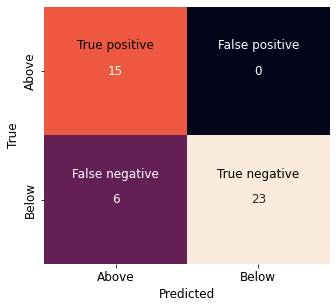

In [8]:
# classification prediction of the Ising model
Xtrain, Xtest, ytrain, ytest = Ising.load_data()

y_test_copy = ytest.copy()

true_tc = 2.269185314213022

## remove temperatures between 2.1 and 2.5 from the training set and test set
# find the indices of the temperatures between 2.1 and 2.5
idx_train = np.where((ytrain > 2.1) & (ytrain < 2.5))
idx_test = np.where((ytest < 2.1) | (ytest > 2.5))

# remove the data points with these indices from the training set
Xtrain = np.delete(Xtrain, idx_train, axis=0)
ytrain = np.delete(ytrain, idx_train, axis=0)

# the test sets are the deleted regions
Xtest = np.delete(Xtest, idx_test, axis=0)
ytest = np.delete(ytest, idx_test, axis=0)


ytrain[ytrain < true_tc] = 0
ytrain[ytrain >= true_tc] = 1
ytest[ytest < true_tc] = 0
ytest[ytest >= true_tc] = 1


# shuffle y_copy in the exact same way as Xtrain and Xtest

# use the convolutional neural network to classify the data into two classes
# first reshape Xtrain and Xtest to 4D arrays
Xtrain = Xtrain.reshape(Xtrain.shape[0], 50, 50, 1)
Xtest = Xtest.reshape(Xtest.shape[0], 50, 50, 1)

# create model
model = Sequential()
# add model layers
l2_reg = regularizers.l2(0.01)
model.add(
    Conv2D(
        6,
        kernel_size=5,
        activation='leaky_relu',
        input_shape=(50, 50, 1),
        kernel_regularizer=l2_reg,
        padding='same',
    )
)
# model.add(AveragePooling2D(pool_size=(4, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(
    Conv2D(
        16,
        kernel_size=5,
        activation='leaky_relu',
        kernel_regularizer=l2_reg,
        padding='same',
    )
)
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(AveragePooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(120, activation='relu', kernel_regularizer=l2_reg))
model.add(Dense(84, activation='relu', kernel_regularizer=l2_reg))
model.add(Dense(1, activation='sigmoid'))

# compile model using accuracy to measure model performance
sgd = SGD(learning_rate=0.001, decay=5e-6, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(Xtrain, ytrain, validation_data=(Xtest, ytest), epochs=400, verbose=1)

# evaluate the model
pred = model.predict(Xtest)
soft_pred = pred
hard_pred = np.round(pred)
acc = accuracy_score(ytest, hard_pred)
print('accuracy with CNN = ', acc)

# plot confusion matrix with seaborn
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(13 * cmt, 12 * cmt))
cm = confusion_matrix(ytest, hard_pred)
sns.heatmap(cm, annot=True, fmt='d')
# remove colorbar
plt.gca().collections[0].colorbar.remove()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# label as true positive, true negative, false positive, false negative
plt.text(
    0.5,
    0.3,
    'True positive',
    ha='center',
    va='center',
    color='black',
    fontsize=12,
)
plt.text(
    1.5,
    0.3,
    'False positive',
    ha='center',
    va='center',
    color='white',
    fontsize=12,
)
plt.text(
    0.5,
    1.3,
    'False negative',
    ha='center',
    va='center',
    color='white',
    fontsize=12,
)
plt.text(
    1.5,
    1.3,
    'True negative',
    ha='center',
    va='center',
    color='black',
    fontsize=12,
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0.5, 1.5], ['Above', 'Below'])
plt.yticks([0.5, 1.5], ['Above', 'Below'])


plt.show()


In [ ]:
for i in range(1, 11):

    data = pd.read_csv(f"../Ising/data/50/ahmeds_configs/{i}.txt", header=None, sep="\t")
    data = data.to_numpy().reshape(80, 80)

    # discard the first 30 rows and 30 columns
    data = data[30:, 30:]

    # reshape the data to 4D array
    data = data.reshape(1, 50, 50, 1)

    pred = model.predict(data, verbose=0)
        
    print("File number: ", i)
    if pred > 0.5:
        print("Above critical temperature")
    else:
        print("Below critical temperature")

File number:  1
Below critical temperature
File number:  2
Above critical temperature
File number:  3
Below critical temperature
File number:  4
Above critical temperature
File number:  5
Below critical temperature
File number:  6
Above critical temperature
File number:  7
Below critical temperature
File number:  8
Above critical temperature
File number:  9
Below critical temperature
File number:  10
Above critical temperature
